## **10. 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법**

### **데이터 사전 처리(Preprocessing)**

- 데이터 가공을 많이 수행할 예정이므로 원본 csv 파일 기반의 DataFrame은 보관하고, 복사해서 데이터 가공

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org=pd.read_csv(r"C:\Users\이희원\OneDrive\바탕 화면\EWHA\4-1\ESAA\kaggle_data\house_price.csv")
house_df=house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
print('데이터 세트의 Shape :', house_df.shape)
print('\n전체 피처의 type\n', house_df.dtypes.value_counts())
isnull_series=house_df.isnull().sum()
print('\nNull 칼럼과 그 건수 :\n', isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 Shape : (1460, 81)

전체 피처의 type
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수 :
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


- 데이터 양에 비해 Null 값이 많은 피처(PoolQC, MiscFeature, Alley, Fence) 드롭

<Axes: title={'center': 'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

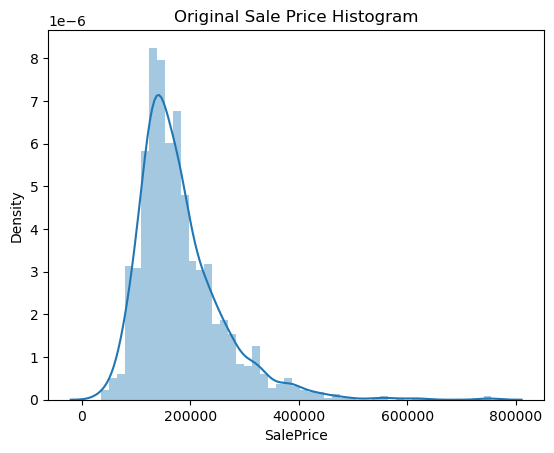

In [4]:
# 회귀 모델을 적용하기 전에 타깃 값의 분포도가 정규 분포인지 확인
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

- 데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로, 정규 분포에서 벗어나 있음

<Axes: title={'center': 'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

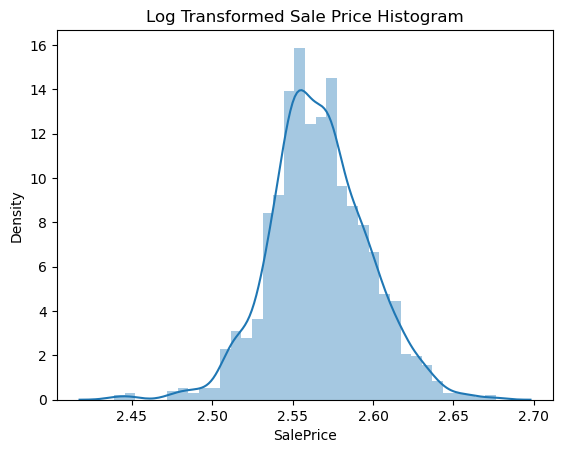

In [28]:
# 정규 분포가 아닌 결괏값을 정규 분포 형태로 변환하기 위해 로그 변환(Log Transformation)을 적용
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice=np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [6]:
# SalePrice 로그 변환
original_SalePrice=house_df['SalePrice']
house_df['SalePrice']=np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count=house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


- 문자형 피처를 모두 원-핫 인코딩으로 변환 (판다스의 get_dummies()이용)  
- get_dummies()는 자동으로 문자열 피처를 원-핫 인코딩 변환하면서 Null 값은 'None' 칼럼으로 대체해주기 때문에 별도의 Null 값을 대체하는 로직이 필요 없음  
- 원-핫 인코딩을 적용하면 칼럼이 증가하는데, 변환 후 얼마나 칼럼이 늘어났는지 확인

In [7]:
print('get_dummies() 수행 전 데이터 Shape :', house_df.shape)
house_df_ohe=pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape :', house_df_ohe.shape)

null_column_count=house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape : (1460, 75)
get_dummies() 수행 후 데이터 Shape : (1460, 270)
## Null 피처의 Type :
 Series([], dtype: object)


- 원-핫 인코딩 후 피처가 75개에서 272개로 증가  
- Null 값을 가진 피처는 이제 존재X

### **선형 회귀 모델 학습/예측/평가**

In [29]:
# 여러 모델의 로그 변환된 RMSE를 측정할 것이므로 이를 계산하는 함수 생성
def get_rmse(model):
    pred=model.predict(X_test)
    mse=mean_squared_error(y_test, pred)
    rmse=np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE :', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses=[]
    for model in models:
        rmse=get_rmse(model)
        rmses.append(rmse)
    return rmses

- get_rmse(model)은 단일 모델의 RMSE 값을, get_rmses(models)는 get_rmse()를 이용해 여러 모델의 RMSE 값을 반환

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso()
lasso_reg.fit(X_train, y_train)

models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE : 0.132
Ridge 로그 변환된 RMSE : 0.127
Lasso 로그 변환된 RMSE : 0.176


[0.1318318468825032, 0.1274058283626614, 0.17628250556471403]

- 라쏘 회귀의 경우 회귀 성능이 타 회귀 방식보다 많이 떨어지는 결과가 나옴 => 최적 하이퍼 파라미터 튜닝 필요  
- 피처별 회귀 계쑤를 시각화해서 모델별로 어떠한 피처의 회귀 계수로 구성되는지 확인  
- 피처가 많으니 회귀 계수 값의 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 가지는 판다스 Series 객체를 반환하는 함수 만들기

In [10]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체 생성. index는 칼럼명
    coef=pd.Series(model.coef_, index=X_features.columns)
    
    #+ 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환
    coef_high=coef.sort_values(ascending=False).head(n)
    coef_low=coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

- 생성한 get_top_bottoms(model, n=10) 함수를 이용해 모델별 회귀 계수 시각화  
- 시각화를 위한 함수로 visualize_coefficient(models) 생성 => list 객체로 모델을 입력받아 모델별로 회귀 계수 상위 10개, 하위 10개를 추출해 가로 막대 그래프 형태로 출력

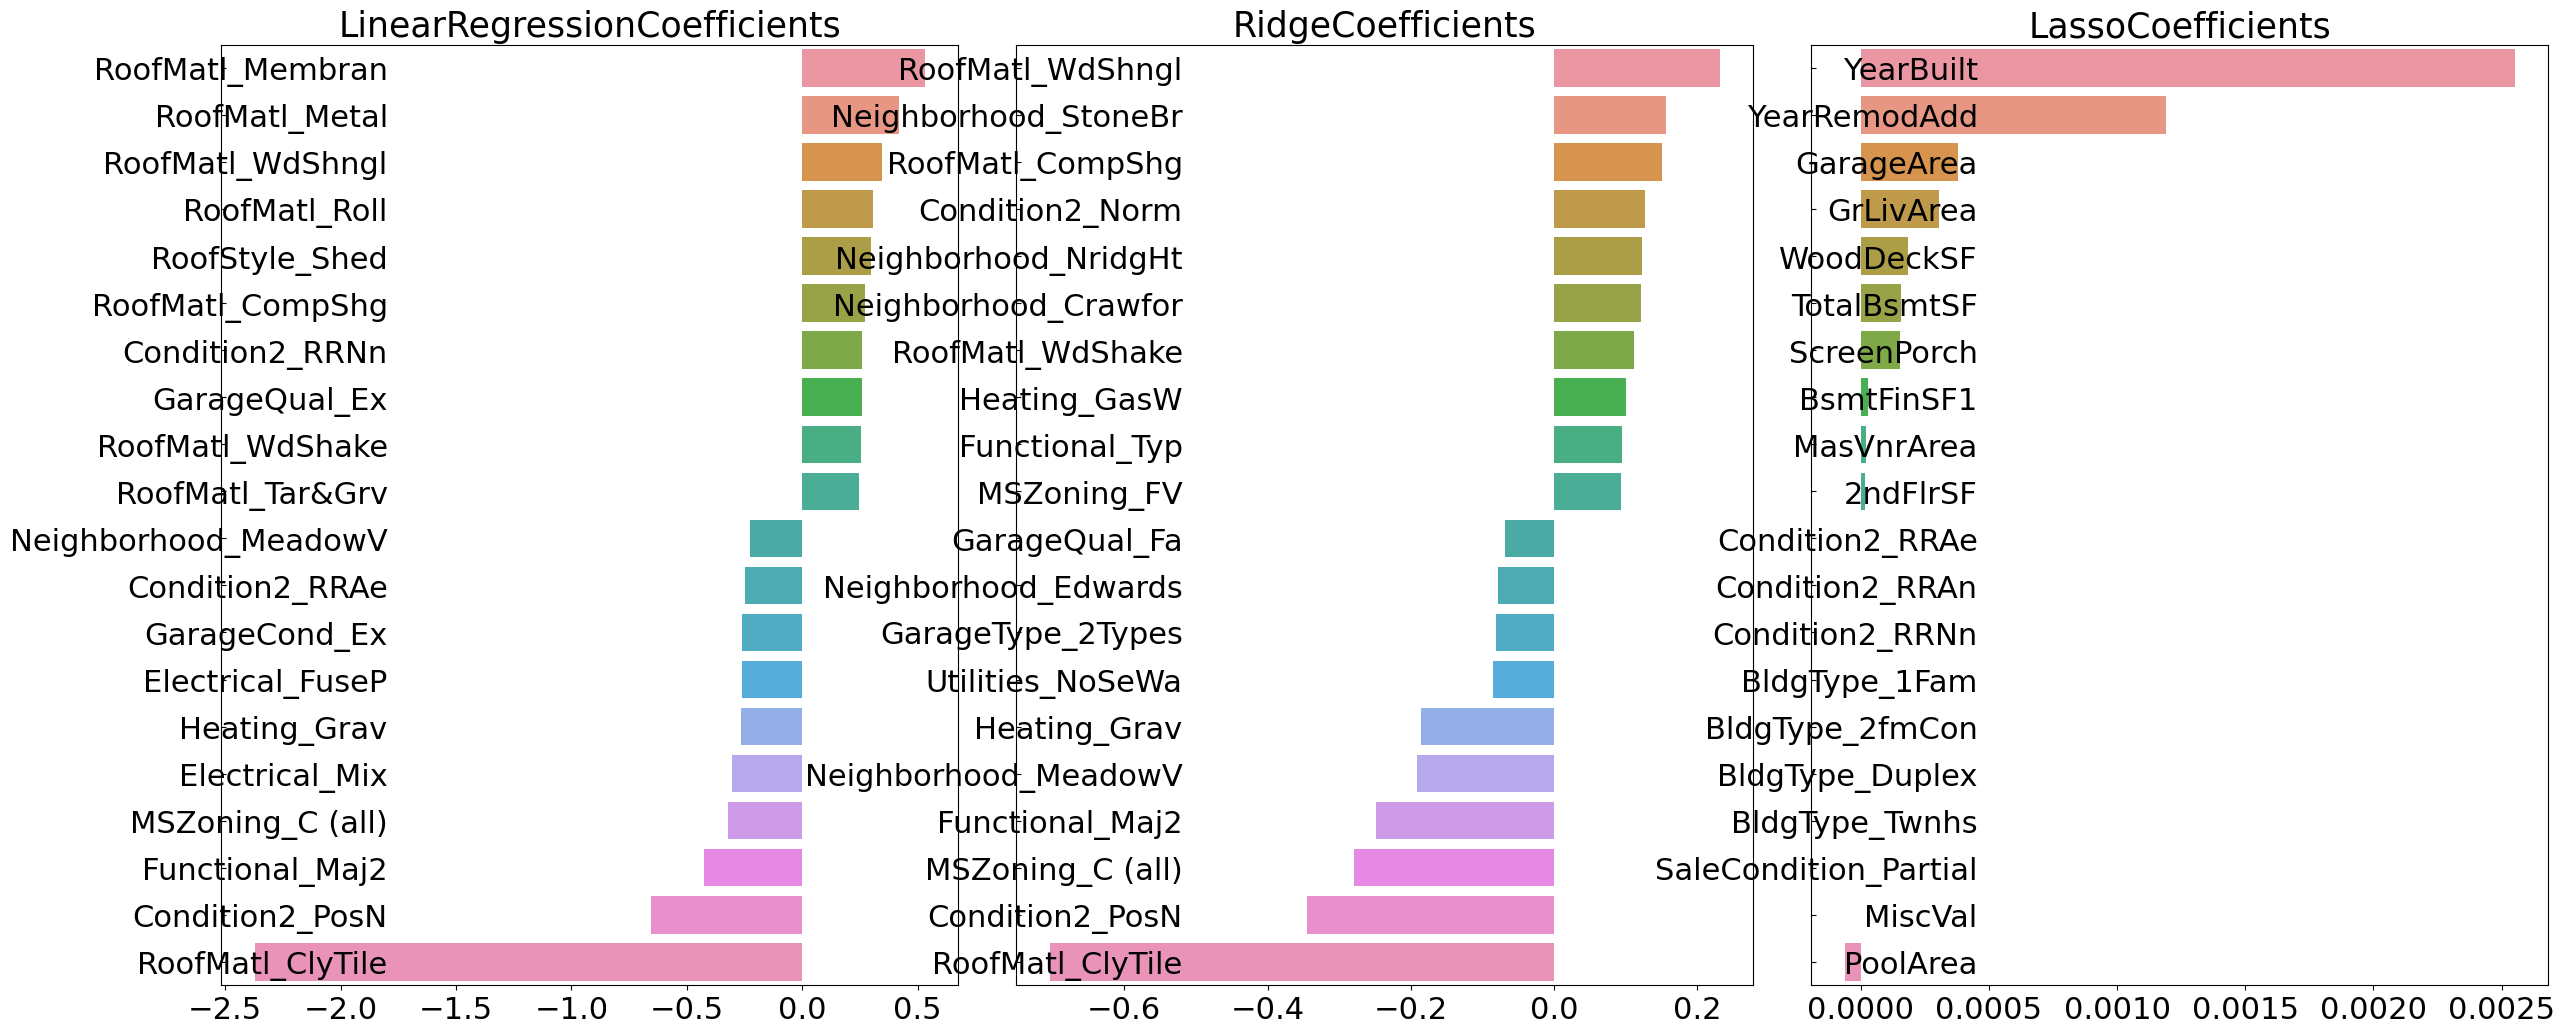

In [11]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs=plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low=get_top_bottom_coef(model)
        coef_concat=pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__+'Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 모델별 회귀 계수를 보면 OLS 기반의 LinearRegression과 Ridge의 경우 회귀 계수가 유사한 형태로 분포되어 있음  
- BUT 라쏘는 전체적으로 회귀 계수 값이 매우 작고, 그중에 YearBuilt가 가장 크고 다른 피처의 회귀 계수는 너무 작음  
- 혹시 학습 데이터의 데이터 분할에 문제가 있어서 그럴 수도 있으니, 이번에는 학습과 테스트 데이터 세트를 분할하지 않고 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE 측정 => cross_val_score() 이용

In [12]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE 값과 평균 RMSE 출력
        rmse_list=np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        rmse_avg=np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값 : {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트 : [0.135 0.165 0.167 0.111 0.198]
LinearRegression CV 평균 RMSE 값 : 0.155

Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값 : 0.144

Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값 : 0.198


- 5개의 폴드 세트로 학습한 후 평가해도 여전히 라쏘의 경우가 OLS 모델이나 릿지 모델보다 성능이 떨어짐
- 릿지와 라쏘 모델에 대해서 alpha 하이퍼 파라미터를 변화시키면서 최적 값을 도출
- 앞으로 모델별로 최적화 하이퍼 파라미터 작업을 반복적으로 수행하므로 이를 위한 함수 생성 (print_best_params(model, params))

In [13]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model=GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse=np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha : {2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

ridge_params={'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha : {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha : {'alpha': 0.001}


- 라쏘 모델의 경우 alpha 값 최적화 이후 예측 성능이 많이 좋아짐
- 선형 모델에 최적 alpha 값을 설정한 뒤, train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가 수행, 모델별 회귀 계수 시각화

LinearRegression 로그 변환된 RMSE : 0.132
Ridge 로그 변환된 RMSE : 0.124
Lasso 로그 변환된 RMSE : 0.12


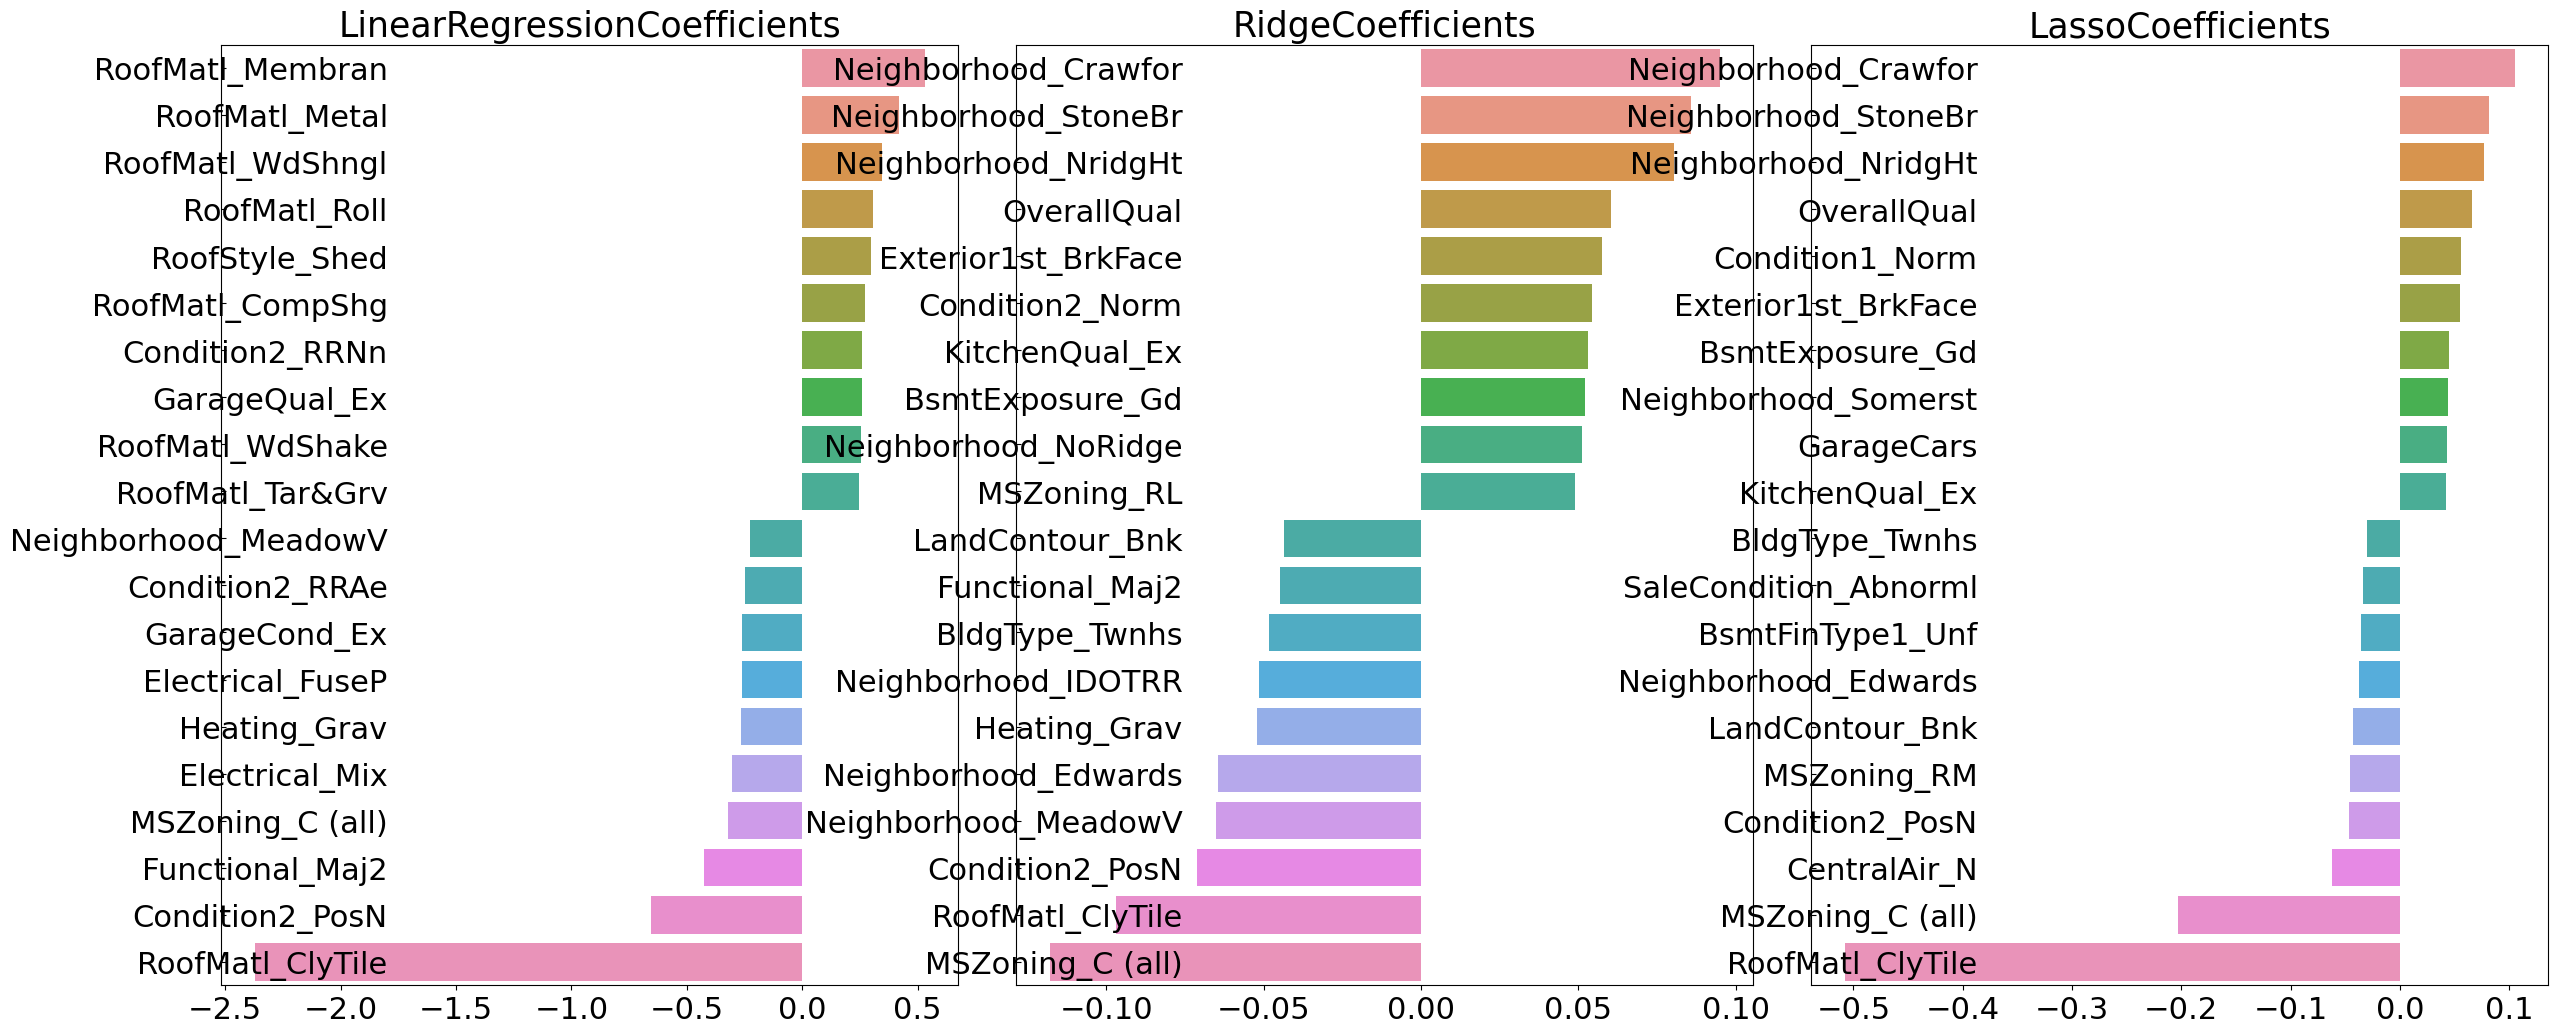

In [14]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- alpha 값 최적화 이후 테스트 데이터 세트의 예측 성능이 개선됨, 모델별 회귀 계수도 많이 달라짐
- 데이터 세트를 추가적으로 가공해서 모델 튜닝 진행
  1. 피처 데이터 세트의 데이터 분포도
  2. 이상치 데이터 처리

- 사이파이 stats 모듈의 skew() 함수를 이용해 칼럼의 데이터 세트의 왜곡된 정도를 쉽게 추출 가능
- 일반적으로 skew() 함수의 반환 값이 1이상인 경우 왜곡 정도가 높다고 판단
- skew()를 적용하는 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처는 제외해야 함
- 카테고리 피처는 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높음
- 따라서 skew() 함수를 적용하는 DataFrame은 원-핫 인코딩이 적용된 house_df_ohe가 아니라 원-핫 인코딩이 적용되지 않은 house_df이어야 함

In [15]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index=house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features=house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출
skew_features_top=skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [30]:
# 추출된 왜곡 정도가 높은 피처를 로그 변환
house_df[skew_features_top.index]=np.log1p(house_df[skew_features_top.index])

In [17]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe=pd.get_dummies(house_df)
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params={'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha : {'alpha': 0.001}


- 다시 위의 train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가 및 모델별 회귀 계수를 시각화

- 세 모델 모두 GrLivArea, 즉 주거 공간 크기가 회귀 계수에 가장 높은 피처가 됨
- 주거 공간의 크기가 주택 가격에 미치는 영향이 당연히 제일 높을 것이라는 상식선에서의 결과가 이제 도출됨

- 다음으로 좀 더 분석할 요소는 이상치 데이터
- 특히 회귀 계수가 높은 피처, 즉 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터 처리가 중요
- 먼저 세 게 모델 모두에서 가장 큰 회귀 계수를 가지는 GrLivArea 피처의 데이터 분포 살펴보기

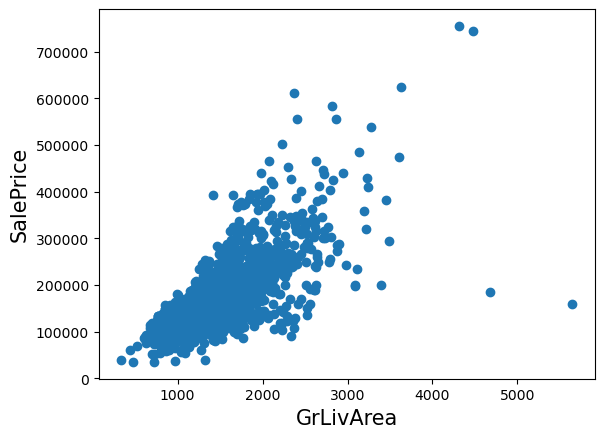

In [31]:
# 주택 가격 데이터가 변환되기 이전의 원본 데이터 세트인 house_df_org에서 GrLivArea와 타깃 값인 SalePrice의 관계를 시각화
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

- 일반적으로 주거 공간이 큰 집일수록 가격이 비싸기 때문에 GrLivArea 피처는 SalePrice와 양의 상관도가 매우 높음을 직관적으로 알 수 있음
- 하지만 우측 하단의 2개의 데이터는 이상치 => 삭제

- 데이터 변환이 모두 완료된 house_df_ohe에서 대상 데이터를 필터링
- GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건을 생성한 뒤, 불린 인덱싱으로 대상 찾기
- 찾은 데이터의 DataFrame 인덱스와 drop()을 이용해 해당 데이터 삭제

In [19]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성
cond1=house_df_ohe['GrLivArea']>np.log1p(4000)
cond2=house_df_ohe['SalePrice']<np.log1p(500000)
outlier_index=house_df_ohe[cond1&cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape :', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape :', house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape : (1460, 270)
이상치 삭제 후 house_df_ohe shape : (1458, 270)


- 업데이터된 house_df_ohe를 기반으로 피처 데이터 세트와 타깃 데이터 세트를 다시 생성하고
- 앞에서 정의한 print_best_params() 함수를 이용해 릿지와 라쏘 모델의 최적화 수행 후 결과 출력

In [20]:
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params={'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha : {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha : {'alpha': 0.001}


- 단 두 개의 이상치 데이터만 제거했는데 예측 수치가 매우 크게 향상됨
- 즉, GrLivArea 속성이 회귀 모델에서 차지하는 영향도가 크기에, 이 이상치를 개선하는 것이 성능 개선에 큰 의미를 가짐
- 회귀에 중요한 영향을 미치는 피처를 위주로 이상치 데이터를 찾으려는 노력은 중요함
- 보통 머신러닝 프로세스 중에서 데이터의 가공은 알고리즘을 적용하기 이전에 수행
- 하지만 이것이 머신러닝 알고리즘을 적용하기 이전에 완벽하게 데이터의 선처리 작업을 수행하라는 의미는 아님
- 일단 대략의 데이터 가공과 모델 최적화를 수행한 뒤 다시 이에 기반한 여러 가지 기법의 데이터 가공과 하이퍼 파라미터 기반의 모델 최적화를 반복적으로 수행하는 것이 바람직한 머신러닝 모델 생성 과정

### **회귀 트리 모델 학습/예측/평가**

- XGBoost, LightGBM 모두 수행 시간이 오래 걸릴 수 있는 관계로 다음과 같은 하이퍼 파라미터 설정을 미리 적용한 상태로 5 폴드 세트에 대한 평균 RMSE 값 구하기

In [21]:
from xgboost import XGBRegressor

xgb_params={'n_estimators' : [1000]}
xgb_reg=XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1184, 최적 alpha : {'n_estimators': 1000}


In [22]:
from lightgbm import LGBMRegressor

lgbm_params={'n_estimators' : [1000]}
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

### **회귀 모델의 예측 결과 혼합을 통한 최종 예측**

- 앞에서 구한 릿지 모델과 라쏘 모델을 서로 혼합
- 최종 혼합 모델, 개별 모델의 RMSE 값을 출력하는 get_rmse_pred() 함수를 생성하고 각 모델의 예측값을 계산한 뒤 개별 모델과 최종 혼합 모델의 RMSE 구하기

In [23]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value=preds[key]
        mse=mean_squared_error(y_test, pred_value)
        rmse=np.sqrt(mse)
        print('{0} 모델의 RMSE : {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg=Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred=ridge_reg.predict(X_test)
lasso_pred=lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred=0.4*ridge_pred+0.6*lasso_pred
preds={'최종 혼합' : pred, 'Ridge' : ridge_pred, 'Lasso' : lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.10006075517615193
Ridge 모델의 RMSE : 0.10340697165289348
Lasso 모델의 RMSE : 0.10024171179335338


- 릿지, 라쏘 중 성능이 조금 좋은 쪽에 가중치를 약간 더 둔 것 (릿지*0.4, 라쏘*0.6)
- 가중치를 정하는 특별한 기준은 없음

- 이번에는 XGBoost와 LightGBM 혼합

In [24]:
xgb_reg=XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred=xgb_reg.predict(X_test)
lgbm_pred=lgbm_reg.predict(X_test)

pred=0.5*xgb_pred+0.5*lgbm_pred
preds={'최종 혼합' : pred, 'XGBM' : xgb_pred, 'LGBM' : lgbm_pred}
get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
최종 혼합 모델의 RMSE : 0.1014930603755743
XGBM 모델의 RMSE : 0.10608167218368826
LGBM 모델의 RMSE : 0.10363891833477148


### **스태킹 앙상블 모델을 통한 회귀 예측**

- 스태킹 모델의 구현 방법
  1. 두 종류의 모델 필요: 개별적인 기반 모델, 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델
  2. 스태킹 모델의 핵심: 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것
  3. 최종 메타 모델이 학습할 피처 데이터 세트: 원본 학습 피처 세트로 학습한 개별 모델의 예측값을 스태킹 형태로 결합한 것

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf=KFold(n_splits=n_folds, shuffle=True, random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred=np.zeros((X_train_n.shape[0], 1))
    test_pred=np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트 :', folder_counter, '시작')
        X_tr=X_train_n[train_index]
        y_tr=y_train_n[train_index]
        X_te=X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter]=model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean=np.mean(test_pred, axis=1).reshape(-1,1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

- 이제 get_stacking_base_datasets()를 모델별로 적용해 메타 모델이 사용할 학습 피처 데이터 세트와 테스트 피처 데이터 세트를 추출
- 적용할 개별 모델: 릿지, 라쏘, XGBoost, LightGBM

In [26]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n=X_train.values
X_test_n=X_test.values
y_train_n=y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test=get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test=get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test=get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test=get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
Lasso model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
XGBRegressor model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
LGBMRegressor model 시작
	 폴드 세트 : 0 시작
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2958
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 161
[LightGBM] [Info] Start training from score 12.021282
	 폴드 세트 : 1 시작
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2942
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 158
[LightGBM] [Info] Start training from sc

- 각 개별 모델이 반환하는 학습용 피처 데이터와 테스트용 피처 데이터 세트를 결합해 최종 메타 모델에 적용
- 메타 모델은 별도의 라쏘 모델 이용
- 최종적으로 예측 및 RMSE 측정

In [27]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train=np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test=np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso=Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final=meta_model_lasso.predict(Stack_final_X_test)
mse=mean_squared_error(y_test, final)
rmse=np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값 :', rmse)

스태킹 회귀 모델의 최종 RMSE 값 : 0.09746226758007757


- 현재까지 가장 좋은 성능 평가 보여줌

## **11. 정리**

[머신러닝 기반의 회귀]
- 선형 회귀
- 비용 함수
- 경사 하강법: 비용 함수 최소화 방법
- 단순 선형회귀와 과적합
- 규제(Regularization)
- 대표적인 규제 선형 회귀: L2 규제를 적용한 릿지, L1 규제를 적용한 라쏘, L1와 L2를 적용한 엘라스틱넷
- 로지스틱 회귀 => 선형 회귀를 분류에 적용
- 회귀 트리를 이용한 예측
- 데이터 값의 분포도와 인코딩 방법에 많은 영향을 받음
- 원-핫 인코딩을 통한 데이터 변환